## Caso grupal 2:  Implementación y agregación de segmentadores
#### Grupo 18 Equipo 9: Miembros
Alberto Rodríguez Álvarez  
Andrés Molares Ulloa  
Mario García Mayo  
Xavier Castilla Carbonell

#### Descripción del problema
En esta práctica se busca detectar y delimitar vehículos aéreos.

#### Solución planteada
Para lograr el objetivo se deciden implementar un total de cuatro segmentadores distintos (Mean Shift, Kmeans, Graph Cut y Watershed) y realizar una agregación de dichos segmentadores. Finalmente se realizará una serie de pruebas para poder comparar los resultados con los distintos segmentadores estudiados y extraer unas conclusiones al respecto.

#### Desarrollo del ejecicio

In [146]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.patches as patches
import pandas as pd

In [147]:
img1 = 'avion.jpg'
img2 = 'avion2.jpeg'
img3 = 'avion3.jpeg'
img4 = 'avion4.jpeg'

# Mean Shift

In [148]:
def mean_shift_segmentation(img):
    im = cv2.imread(img)
    im = cv2.resize(im,dsize=(750,500))
    #shape devuelve tres valores, el ultimo es el numero de cnaales de color
    tam = im.shape
    #Para poder ejecutar el algoritmo mean shift en sklearn necesitamos calcular el parametro bandwith
    #para calcular este parametro disponemos de una funcion a la que le tenemos que pasar la imagen en un array de 2d

    im2d=np.reshape(im, [-1,3]) # array 2d todos los pixeles por un lado y por el otro los canales de color
    bandwidth = estimate_bandwidth(im2d, n_samples = 100, quantile=0.2)

    #utilizams el parametro bin seeding para que no se usen todos los puntos si no que se coja una por cuadricula
    res = MeanShift(bandwidth, bin_seeding=True)
    res.fit(im2d)
    
    # obserar que etiquetas corresponden a background y cuales a foreground
    unique, counts = np.unique(res.labels_, return_counts=True)
    dict(zip(unique, counts))
    
    #dejar un cluster para background y otro para foreground
    for it, i in enumerate(res.labels_):
        if i!=2:
            res.labels_[it]=0
        else:
            res.labels_[it]=1
            
    # Numero de pixeles del background (0) y del foreground (1)
    unique, counts = np.unique(res.labels_, return_counts=True)
    dict(zip(unique, counts))
    
    # pintar la imagen segmentada 
    seg = res.cluster_centers_[np.reshape(res.labels_, tam[:2])]

    seg_RGB = seg[...,::-1]
    segmentacion_mean_shift = res.labels_.reshape(tam[:2])
    return segmentacion_mean_shift

# Kmeans

In [149]:
#Función de segmentación con un algorítmo K-means, devuelve la imagen segmentada
# K: Numero de etiquetas máximas a encontrar
# attemps: Número de ejecuciones con diferentes etiquetas iniciales
def segmentacionKmeans(img, K, attempts = 10, showImage = False):
  img = cv2.imread(img)
  img = cv2.resize(img,dsize=(750,500))
  Z = img.reshape((-1,3))

  # convertimos a numpy float32 que es el tipo de dato con el que trata cv2.kmeans
  Z = np.float32(Z)

  # definimos el criterio TERM_CRITERIA_EPS = epsiolon máxima del algorítmo k-means o TERM_CRITERIA_MAX_ITER = número de iteraciones máximas
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

  #Función K-means con puntos centrales aleatorios (KMEANS_RANDOM_CENTERS)
  compactness,label,center=cv2.kmeans(data = Z, K = K, bestLabels = None, criteria = criteria,
                              attempts = attempts, flags = cv2.KMEANS_RANDOM_CENTERS)

  # Reconvertimos la imagen a su tamaño original
  center = np.uint8(center)
  res = center[label.flatten()]

  imagenSegmentada = cv2.cvtColor(res.reshape((img.shape)),cv2.COLOR_RGB2GRAY)
    
  trash, imagenSegmentada = cv2.threshold(imagenSegmentada,0,1,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

  if showImage:
    print(np.unique(label))
    plt.imshow(imagenSegmentada)
  
  return imagenSegmentada


def segmentacionKmeansBinary(img, attempts = 10, showImage = False):
  return segmentacionKmeans(img, 2, attempts, showImage)


# Graph Cut

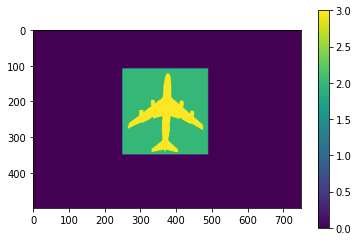

(<matplotlib.image.AxesImage at 0x7fd5657f0190>,
 None)

In [150]:
#Cargar imagen
img = cv2.imread(img3)
#Pasar a RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#cambiar tamaño de imagen para que no sea demasiado pesado el alg
img = cv2.resize(img,dsize=(750,500))
#Creamos la mácara de segmentación vacía
mask = np.zeros(img.shape[:2],np.uint8)

#Inicializamos los modelos de BG y FG
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

#Introducimos manualmente la región de interes (el FG tiene que estár completamente contenido en el rectangulo)
rect = (250,110,240,240)

#Llamamos a GraphCut con 1 iteración
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,1,cv2.GC_INIT_WITH_RECT)

#Mostramos el resultado (valor 0 indica background fuera del rectangulo, 2 background dentro del rectangulo y 3 Foreground)
plt.imshow(mask),plt.colorbar(),plt.show()

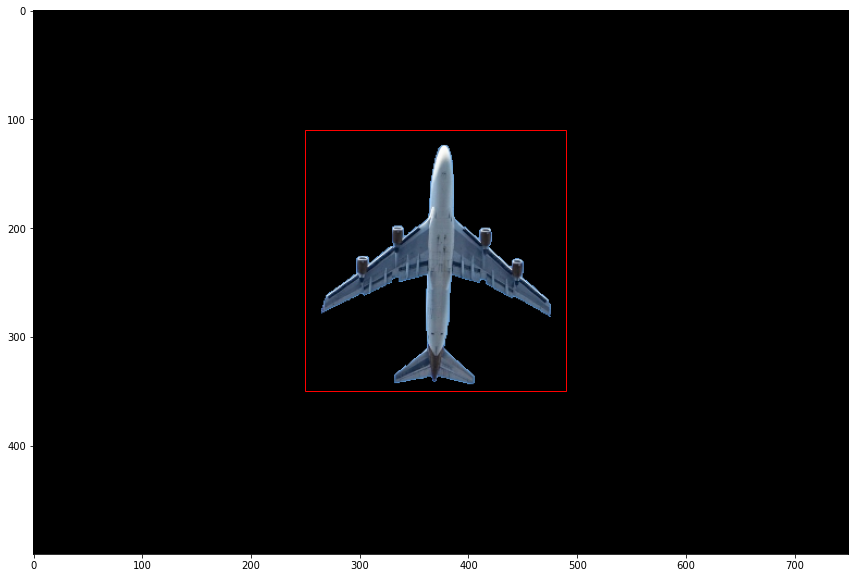

In [151]:
#binarizamos la mascara a FG y BG solo
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')

#Nos quedamos solo con el FG
FG = img*mask2[:,:,np.newaxis]

#Mostramos la imagen resultante con el rectangulo selccionado
fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(FG)
rect2 = patches.Rectangle((rect[0],rect[1]), rect[2], rect[3], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect2)
plt.show()

### Pipeline
Función parametrizada

In [152]:
def graph_cut_segmentation(path,dsize,rect,it):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,dsize=dsize)
    
    mask = np.zeros(img.shape[:2],np.uint8)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    
    cv2.grabCut(img,mask,rect,bgdModel,fgdModel,it,cv2.GC_INIT_WITH_RECT)
    
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')

    return mask2


# Watershed

In [153]:
def watershed_segmentation(img, umbral):
    img = cv2.imread(img)
    img = cv2.resize(img,dsize=(750,500))
    gris = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    trash, thresh = cv2.threshold(gris,umbral,255,cv2.THRESH_BINARY_INV)
    # Eliminado del ruido
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    # Se determina el area del background
    sure_bg = cv2.dilate(opening,kernel,iterations=3)
    # Se determina el area del foreground
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    trash, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
    # Se acota la región a analizar
    sure_fg = np.uint8(sure_fg)
    desconocida = cv2.subtract(sure_bg,sure_fg) 
    # Se definen las semillas
    trash, marcadores = cv2.connectedComponents(sure_fg)
    marcadores = marcadores+1 #Se evita que la etiqueta fondo tenga valor 0
    # Se marca la región desconocida con ceros
    marcadores[desconocida==255] = 0
    marcadores = cv2.watershed(img,marcadores)
    img[marcadores == -1] = [255,0,0]
    
    # Se resume la informacion de segmentado en dos clases
    for i in range(marcadores.shape[0]):
        for j in range(marcadores.shape[1]):
            if marcadores[i,j] == 1:
                marcadores[i,j] = 0
            else:
                marcadores[i,j] = 1
    return marcadores

# Evaluación de los segmentadores 

### Función de evaluación

In [154]:
#Dada la segmetación binaria de y el Ground Truth se calculan diferentes métricas

def evaluation(Ground,mask,verbose=True):
    
    #Se calculan las mascaras inversas
    Ground_inv = np.where(Ground==0, 1, 0)
    mask_inv = np.where(mask==0, 1, 0)
    
    #Calculamos los componentes de la matriz de confusión
    TP=np.sum(np.multiply(Ground,mask))
    TN=np.sum(np.multiply(Ground_inv,mask_inv))
    FP=np.sum(np.multiply(Ground_inv,mask))
    FN=np.sum(np.multiply(Ground,mask_inv))
    
    #Calculamos la unión de las máscaras
    U=np.sum(Ground+mask)/2
    
    #Construimos la matriz de confusión
    cm=np.array([[TP,FP],[FN,TN]])
    
    #Calculamos las metricas
    accuracy = (TP + TN)/(TP + TN + FP + FN)
    error = 1 - accuracy
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    F1 = 2*precision*recall / (precision + recall)
    sensibility = recall
    specificity = TN / (TN + FP)
    
    #Se imprimen los resultados si se le ha pedido
    if verbose:
        #plot_cm(cm)
        print('Accuracy    = {:.0f}%'.format(accuracy*100))
        print('Error       = {:.0f}%'.format(error*100))
        print('Precision   = {:.0f}%'.format(precision*100))
        print('Recall      = {:.0f}%'.format(recall*100))
        print('F1_score    = {:.0f}%'.format(F1*100))
        print('Sensibilidad= {:.0f}%'.format(sensibility*100))
        print('Specificidad= {:.0f}%'.format(specificity*100))
        print('IoU         = {:.0f}%'.format(TP/U*100))
        
    #Se enpaquetan las metricas para devolverlas
    metrics={'TP':TP,'TN':TN,'FP':FP,'FN':FN,'IoU':TP/U,'Accuracy':accuracy,'Error':error,'Precision':precision,'Recall':recall,'F1_score':F1,'Sensibility':sensibility,'Specificity':specificity,'CMatrix':cm}
    
    return metrics


#función para pintar la matriz de confusión bonita
def plot_cm(cm):
    n_classes = 2
    fig, ax = plt.subplots()
    ax.imshow(cm, interpolation='nearest', cmap='viridis')
    ax.set(xticks=np.arange(n_classes), yticks=np.arange(n_classes), xticklabels=('FG','BG'), yticklabels=('FG','BG'), ylabel="True label", xlabel="Predicted label")
    for i in range(n_classes):
        for j in range(n_classes):
            text_cm = format(cm[i, j], '.2g')
            ax.text( j, i, text_cm, ha="center", va="center",color='w')
    ax.set_ylim((n_classes - 0.5, -0.5))

# Votación

Se procede a definir la función de votación, función encargada de agregar los cuatro segmentadores obteniendo de esta forma una segmentación ponderada. 

In [155]:
def votacion(m1,m2,m3,m4):
    m1d = m1.ravel()/(np.max(m1))
    m2d = m2.ravel()/(np.max(m2))
    m3d = m3.ravel()/(np.max(m3))
    m4d = m4.ravel()/(np.max(m4))
    result = np.array(np.zeros(m1.shape))
    r = result.ravel()
    for valor in range(len(m1d)):
        cero = 0
        uno = 0
        if m1d[valor]==0:
            cero +=1.6
        elif m1d[valor]==1:
            uno+=1.6
        if m2d[valor]==0:
            cero +=0.8
        elif m2d[valor]==1:
            uno+=0.8
        if m3d[valor]==0:
            cero +=0.8
        elif m3d[valor]==1:
            uno+=0.8
        if m4d[valor]==0:
            cero +=0.8
        elif m4d[valor]==1:
            uno+=0.8
        if(uno>=2): #dos o mas segmentadores dicen que es fg
            r[valor]=1
        else:
            r[valor]=0
    #pasamos el array-1d a matriz para pintarla  
    r = r.reshape(m1.shape).astype(int)
    return r

# Pruebas

In [156]:
#img: Imagen con el ground truth ya definido, se eliminan todas las etiquetas y se covierte a matriz de ceros y unos
def truthBinaryMatrix(img, showImage = False):
  im = cv2.imread(img,0)
  im = cv2.resize(im,dsize=(750,500))
  #im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
  trash, im = cv2.threshold(im,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  for i in range(im.shape[0]):
    for j in range(im.shape[1]):
      if im[i,j] != 0:
        im[i,j] = 1
  if showImage:
    plt.imshow(im)
  return im

img1_test = truthBinaryMatrix('avion_test.jpg')
img2_test = truthBinaryMatrix('avion2_test.jpg')
img3_test = truthBinaryMatrix('avion3_test.jpg')
img4_test = truthBinaryMatrix('avion4_test.jpg')

In [157]:
seg_gc_av1=graph_cut_segmentation(img1,(750,500),(0,120,580,280),1)
seg_ws_av1=watershed_segmentation(img1,100)
seg_ms_av1=mean_shift_segmentation(img1)
seg_km_av1=segmentacionKmeansBinary(img1)
seg_ag_av1 = votacion(seg_gc_av1,seg_ws_av1,seg_ms_av1,seg_km_av1)
segs_av1 = [(seg_gc_av1,'GraphCut_AV1'), (seg_ws_av1,'Watershed_AV1'), (seg_ms_av1,'MeanShift_AV1'), (seg_km_av1,'Kmeans_AV1'), (seg_ag_av1,'Agrupacion_AV1')]

seg_gc_av2=graph_cut_segmentation(img2,(750,500),(160,0,490,300),1)
seg_ws_av2=watershed_segmentation(img2,98)
seg_ms_av2=mean_shift_segmentation(img2)
seg_km_av2=segmentacionKmeansBinary(img2)
seg_ag_av2 = votacion(seg_gc_av2,seg_ws_av2,seg_ms_av2,seg_km_av2)
segs_av2 = [(seg_gc_av2,'GraphCut_AV2'), (seg_ws_av2,'Watershed_AV2'), (seg_ms_av2,'MeanShift_AV2'), (seg_km_av2,'Kmeans_AV2'), (seg_ag_av2,'Agrupacion_AV2')]

seg_gc_av3=graph_cut_segmentation(img3,(750,500),(250,110,240,240),1)
seg_ws_av3=watershed_segmentation(img3,110)
seg_ms_av3=mean_shift_segmentation(img3)
seg_km_av3=segmentacionKmeansBinary(img3)
seg_ag_av3 = votacion(seg_gc_av3,seg_ws_av3,seg_ms_av3,seg_km_av3)
segs_av3 = [(seg_gc_av3,'GraphCut_AV3'), (seg_ws_av3,'Watershed_AV3'), (seg_ms_av3,'MeanShift_AV3'), (seg_km_av3,'Kmeans_AV3'), (seg_ag_av3,'Agrupacion_AV3')]

seg_gc_av4=graph_cut_segmentation(img4,(750,500),(50,200,500,180),1)
seg_ws_av4=watershed_segmentation(img4,28)
seg_ms_av4=mean_shift_segmentation(img4)
seg_km_av4=segmentacionKmeansBinary(img4)
seg_ag_av4 = votacion(seg_gc_av4,seg_ws_av4,seg_ms_av4,seg_km_av4)
segs_av4 = [(seg_gc_av4,'GraphCut_AV4'), (seg_ws_av4,'Watershed_AV4'), (seg_ms_av4,'MeanShift_AV4'), (seg_km_av4,'Kmeans_AV4'), (seg_ag_av4,'Agrupacion_AV4')]

GraphCut_AV1
Accuracy    = 99%
Error       = 1%
Precision   = 94%
Recall      = 100%
F1_score    = 97%
Sensibilidad= 100%
Specificidad= 99%
IoU         = 97%
Watershed_AV1
Accuracy    = 98%
Error       = 2%
Precision   = 95%
Recall      = 94%
F1_score    = 94%
Sensibilidad= 94%
Specificidad= 99%
IoU         = 94%
MeanShift_AV1
Accuracy    = 99%
Error       = 1%
Precision   = 100%
Recall      = 93%
F1_score    = 96%
Sensibilidad= 93%
Specificidad= 100%
IoU         = 96%
Kmeans_AV1
Accuracy    = 99%
Error       = 1%
Precision   = 100%
Recall      = 95%
F1_score    = 97%
Sensibilidad= 95%
Specificidad= 100%
IoU         = 97%
Agrupacion_AV1
Accuracy    = 99%
Error       = 1%
Precision   = 99%
Recall      = 96%
F1_score    = 98%
Sensibilidad= 96%
Specificidad= 100%
IoU         = 98%


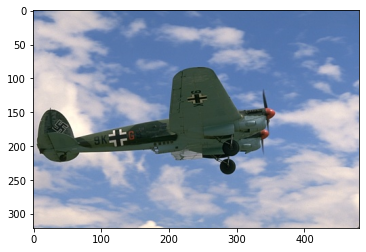

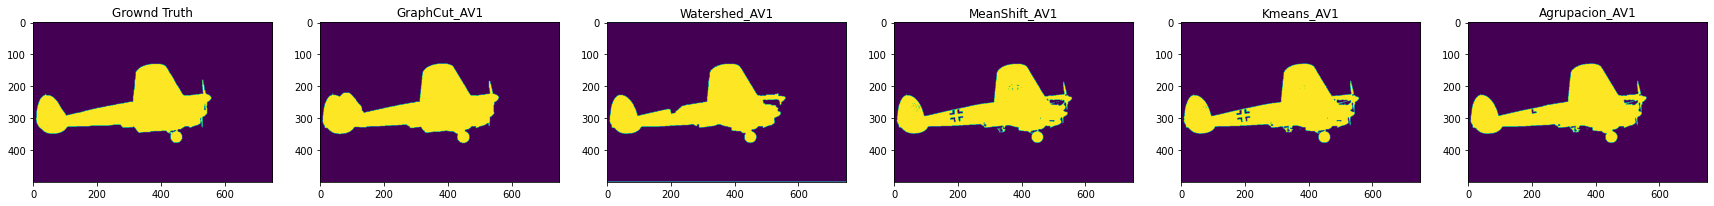

In [158]:
im1 = cv2.imread(img1)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
plt.imshow(im1)
fig, axs = plt.subplots(1,6,figsize=(30,20))
axs[0].set_title('Grownd Truth')
axs[0].imshow(img1_test)
iter = 1
for i in segs_av1:
    print(i[1])
    axs[iter].set_title(i[1])
    axs[iter].imshow(i[0])
    out = evaluation(img1_test,i[0])
    iter = iter+1

GraphCut_AV2
Accuracy    = 87%
Error       = 13%
Precision   = 40%
Recall      = 96%
F1_score    = 57%
Sensibilidad= 96%
Specificidad= 86%
IoU         = 57%
Watershed_AV2
Accuracy    = 91%
Error       = 9%
Precision   = 50%
Recall      = 28%
F1_score    = 36%
Sensibilidad= 28%
Specificidad= 97%
IoU         = 36%
MeanShift_AV2
Accuracy    = 86%
Error       = 14%
Precision   = 0%
Recall      = 0%
F1_score    = 0%
Sensibilidad= 0%
Specificidad= 94%
IoU         = 0%
Kmeans_AV2
Accuracy    = 87%
Error       = 13%
Precision   = 36%
Recall      = 63%
F1_score    = 46%
Sensibilidad= 63%
Specificidad= 89%
IoU         = 46%
Agrupacion_AV2
Accuracy    = 97%
Error       = 3%
Precision   = 97%
Recall      = 63%
F1_score    = 77%
Sensibilidad= 63%
Specificidad= 100%
IoU         = 77%


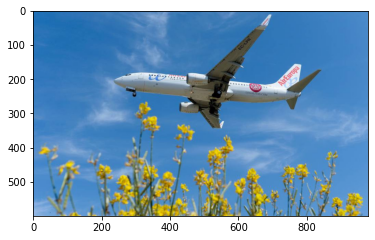

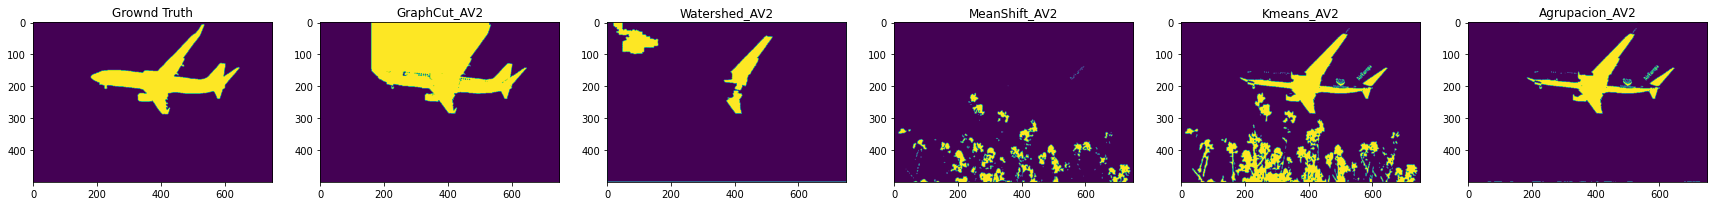

In [159]:
im2 = cv2.imread(img2)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
plt.imshow(im2)
fig, axs = plt.subplots(1,6,figsize=(30,20))
axs[0].set_title('Grownd Truth')
axs[0].imshow(img2_test)
iter = 1
for i in segs_av2:
    print(i[1])
    axs[iter].set_title(i[1])
    axs[iter].imshow(i[0])
    out = evaluation(img2_test,i[0])
    iter = iter+1

GraphCut_AV3
Accuracy    = 97%
Error       = 3%
Precision   = 49%
Recall      = 100%
F1_score    = 65%
Sensibilidad= 100%
Specificidad= 97%
IoU         = 65%
Watershed_AV3
Accuracy    = 98%
Error       = 2%
Precision   = 69%
Recall      = 51%
F1_score    = 58%
Sensibilidad= 51%
Specificidad= 99%
IoU         = 58%
MeanShift_AV3
Accuracy    = 97%
Error       = 3%
Precision   = 99%
Recall      = 16%
F1_score    = 28%
Sensibilidad= 16%
Specificidad= 100%
IoU         = 28%
Kmeans_AV3
Accuracy    = 99%
Error       = 1%
Precision   = 98%
Recall      = 78%
F1_score    = 87%
Sensibilidad= 78%
Specificidad= 100%
IoU         = 87%
Agrupacion_AV3
Accuracy    = 99%
Error       = 1%
Precision   = 99%
Recall      = 81%
F1_score    = 89%
Sensibilidad= 81%
Specificidad= 100%
IoU         = 89%


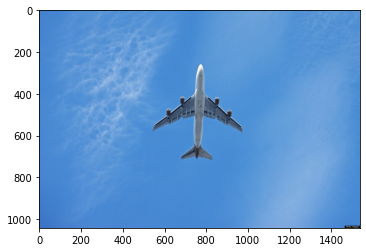

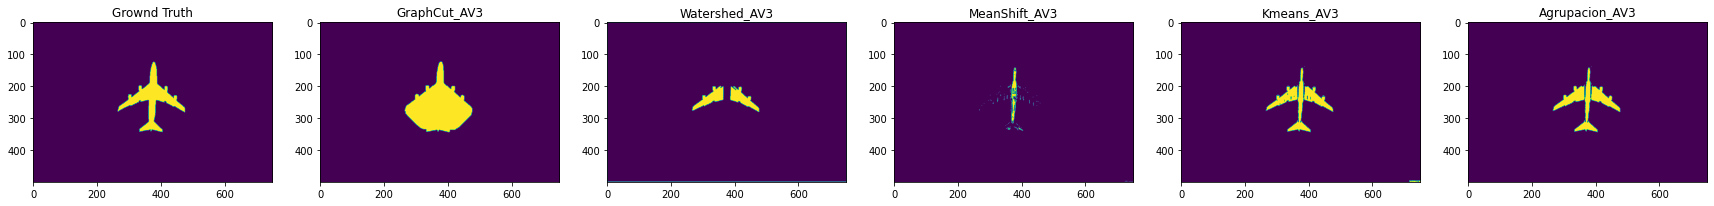

In [160]:
im3 = cv2.imread(img3)
im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2RGB)
plt.imshow(im3)
fig, axs = plt.subplots(1,6,figsize=(30,20))
axs[0].set_title('Grownd Truth')
axs[0].imshow(img3_test)
iter = 1
for i in segs_av3:
    print(i[1])
    axs[iter].set_title(i[1])
    axs[iter].imshow(i[0])
    out = evaluation(img3_test,i[0])
    iter = iter+1

GraphCut_AV4
Accuracy    = 99%
Error       = 1%
Precision   = 89%
Recall      = 100%
F1_score    = 94%
Sensibilidad= 100%
Specificidad= 99%
IoU         = 94%
Watershed_AV4
Accuracy    = 94%
Error       = 6%
Precision   = 78%
Recall      = 32%
F1_score    = 45%
Sensibilidad= 32%
Specificidad= 99%
IoU         = 45%
MeanShift_AV4
Accuracy    = 96%
Error       = 4%
Precision   = 82%
Recall      = 56%
F1_score    = 66%
Sensibilidad= 56%
Specificidad= 99%
IoU         = 66%
Kmeans_AV4
Accuracy    = 29%
Error       = 71%
Precision   = 10%
Recall      = 100%
F1_score    = 17%
Sensibilidad= 100%
Specificidad= 23%
IoU         = 17%
Agrupacion_AV4
Accuracy    = 99%
Error       = 1%
Precision   = 89%
Recall      = 100%
F1_score    = 94%
Sensibilidad= 100%
Specificidad= 99%
IoU         = 94%


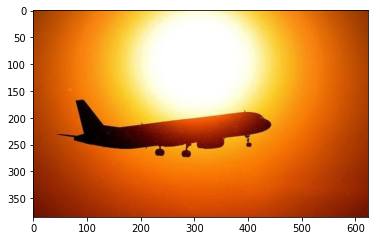

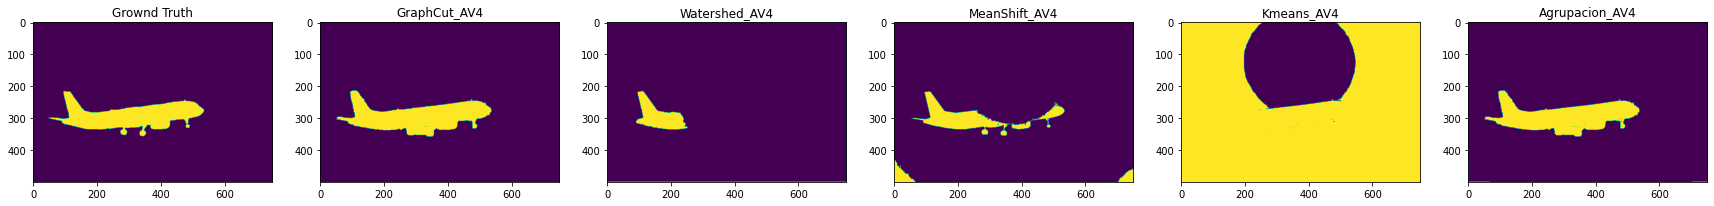

In [161]:
im4 = cv2.imread(img4)
im4 = cv2.cvtColor(im4, cv2.COLOR_BGR2RGB)
plt.imshow(im4)
fig, axs = plt.subplots(1,6,figsize=(30,20))
axs[0].set_title('Grownd Truth')
axs[0].imshow(img4_test)
iter = 1
for i in segs_av4:
    print(i[1])
    axs[iter].set_title(i[1])
    axs[iter].imshow(i[0])
    out = evaluation(img4_test,i[0])
    iter = iter+1

## Conclusiones

El segmentador Graph cut es el que obtiene mejores resultados de los cuatro estudiados en esta práctica, pero hay que tener en cuenta que está limitado a una segmentación binaria.
Aunque para cada imagen hay un segmentador concreto que ofrece los mejores resultados, en general la segmentación obtenida mediante la agrupación de todos los segmentadores es igual o mejor que el resto.